In [1]:
import numpy as np

from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure, sym_matrix_to_vec
from nilearn import plotting

## Data preprocessing

With real neuroimaging data, prepare a dataset and showcase several preprocessing steps. 
This tutorial will focus on minimal data preprocessing, usually required as for most machine-learning methods, with among other things:

- z-scoring of each variable,
- outlier detection,
- missing values processing,
- deconfounding procedures.

#### Useful references
Section 5.1 CCA for neuroscientists: Wang, Hao-Ting, et al. "Finding the needle in a high-dimensional haystack: Canonical correlation analysis for neuroscientists." NeuroImage (2020)

Diana: What I've done so far: 
- download an fmri dataset with 155 subjects, 
- extract for each subject ROI-based functional connectivity feature vector
- function includes optional deconfounding of some common confounding variables thorugh nilearn interface
- generate neuroimaging dataset of the form (Nsubjects x Nfeatures) 


## Downloading neuroimaging data

In this section the goal is to download some neuroimaging data and preprocess it in one dataset that would be ready for further steps of the CCA analysis (for example data reduction or ready to go).

We'll use the nilearn package to fetch the data (https://nilearn.github.io/modules/reference.html#module-nilearn.datasets) 


I started with the "movie watching based brain development dataset (fMRI)" because it's the one that came in the tutorial about extracting the time series and deconfounding. See for more info:

https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_development_fmri.html#nilearn.datasets.fetch_development_fmri

https://openneuro.org/datasets/ds000228/versions/1.0.0

The data will be saved in .....

In [2]:
# Download all subjects of the brain development fmri dataset (both age groups)
data = datasets.fetch_development_fmri(n_subjects=None, reduce_confounds=True, age_group='both')

# data.func is a list of all subject images, let's save that in a variable fmri_filenames
fmri_filenames = data.func

# data.confounds is a list of files that contains confounding variables for each subject
confounds_filenames = data.confounds

## Extracting functional connectivity for each subject

Let's say we want the neuroimaging dataset to contain ROI-based functional connectivity data in the form (N x M) where N is the number of subjects and M is the number of features (ROI-based FC data here), as extracted based on an atlas of ROIs

Steps:
- fetch an atlas of predefined ROIs
- for each subject: 
    - extract time series in each ROI
    - compute connectivity matrix (i.e. matrix of correlations among all ROIs)
    - flatten the lower triangular part of the connectivity matrix into the subject specific feature vector using sym_matrix_to_vec function
- put together the neuroimaging dataset 

I used the tutorial here for this:
https://nilearn.github.io/auto_examples/03_connectivity/plot_signal_extraction.html#sphx-glr-auto-examples-03-connectivity-plot-signal-extraction-py

### 1. Fetch an atlas

The atlas contains 48 ROIs, excluding background. 

Atlas ROIs are located in nifti image (4D) at: C:\Users\dd/nilearn_data\fsl\data\atlases\HarvardOxford\HarvardOxford-cort-maxprob-thr25-2mm.nii.gz

There are 49 ROIs including the background


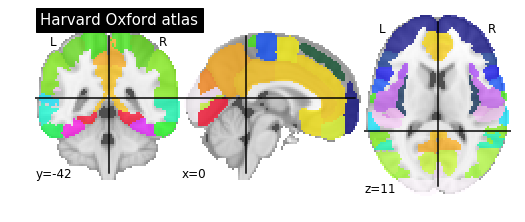

In [4]:
# Fetch the atlas
atlas_dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm') 

print('Atlas ROIs are located in nifti image (4D) at: %s' %
      atlas_dataset.maps)

# visualize the atlas
plotting.plot_roi(atlas_dataset.maps, title='Harvard Oxford atlas')

print("\nThere are %d ROIs (including the background)" % len(atlas_dataset.labels))

### 2. Define a function that returns subject-specific feature vector

This function takes as input the image of a subject, the atlas and optionally, confounding variables to deconfound the time-series data and returns a feature vector corresponding to the lower triangular part of the functional connectivity matrix (diagonal is discarded)

In [5]:
# Function that extracts the feature vector for a given subject
def extract_feature_vector(fmri_img, atlas, confounds=None):
    """
    
    fmri_img : str
        Path to subject fmri image
    
    atlas : ?
        The atlas object containing path to atlas image and list of labels
    
    confounds : str
        Path to subject-specific confound variables. Defaults to None (deconfounding not applied)
    
    Returns
    -------
    Subject feature vector from the FC matrix
    
    """

    atlas_img = atlas.maps
    atlas_labels = atlas.labels

    # Extract signals on a parcellation defined by labels in atlas
    masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=True,
                               memory='nilearn_cache', verbose=0)
    if confounds: #remove confounding variables 
        time_series = masker.fit_transform(fmri_img, confounds=confounds)
    else:
        time_series = masker.fit_transform(fmri_img, confounds=None)
    
    # Compute correlation matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]   #shape 48x48 ROIs
    
    # Flatten the lower triangular part of the connectivity matrix
    feature_vector = sym_matrix_to_vec(correlation_matrix, discard_diagonal=True) #discarding diagonal
    
    return feature_vector, correlation_matrix
    


The feature vector contains 1128 elements


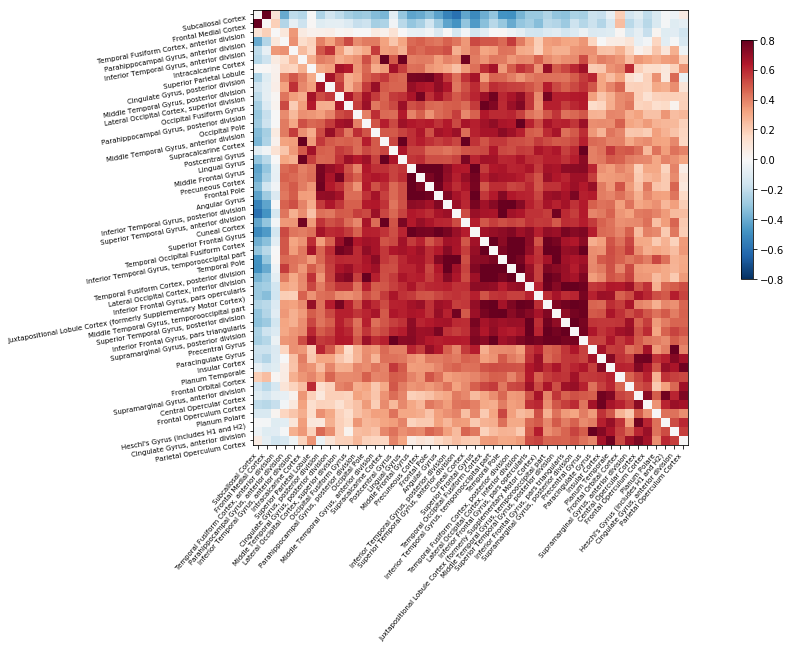

In [6]:
# Test that function works with one subject, for visualization purposes
fmri_img = fmri_filenames[0]
confounds = confounds_filenames[0]

feat_vector, corr_matrix = extract_feature_vector(fmri_img, atlas_dataset, confounds=None)

# plot the correlation matrix
np.fill_diagonal(corr_matrix, 0) #mask the main diagonal for visualization

plotting.plot_matrix(corr_matrix, figure=(10,8), labels=atlas_dataset.labels[1:],    #skip first label since it's background
                     vmax=0.8, vmin=-0.8, reorder=True)

# Since we have 48 ROIs, the expected size of the lower triangular part of the array is 48*(48-1)/2 = 1128
print('\nThe feature vector contains %d elements' %feat_vector.shape)

### 3. Extract the feature vectors for all subjects

And create the imaging dataset

This takes about 5 minutes on my machine since it's 155 subjects

In [7]:
# pre-define dataset array of expected size (155 subjects X 1022 features)
n_subjects = len(fmri_filenames)
n_features = 1128

neuroimaging_dataset = np.zeros((n_subjects, n_features))

for s in range(n_subjects):
    fmri_img = fmri_filenames[s]
    #confounds = confounds_filenames[s]
    
    feat_vector, _ = extract_feature_vector(fmri_img, atlas_dataset, confounds=None)
    neuroimaging_dataset[s,:] = feat_vector
    

In [8]:
neuroimaging_dataset.shape

(155, 1128)

To do:
- Explain more about the deconfounding and explain different options to do it. One is using the nilearn interface, as I did in the tutorial, but another option would be to regress the variables out with a regression (I've never done fmri, so I wonder, at what stage does one deconfound? is it at the time-series level, as I think occurs in nilearn, or could you do it at the end also on your "almost ready" feature dataset, such as the FC dataset I generated here ??? Maybe we could add some discussion on that here


- add traditional z-score standardization


- exemplify outlier detection and missing values and possible ways to deal with them. This can be done either simulating it on the neuroimaging dataset (drop some values here and there, create some outliers first) or on a phenotypic dataset (which the dataset I used here doesn't have, so we should look for a better dataset that has both or simulate some(?)

Some other conclusions
- this data doesn't have "phenotypic" data so it's not that suitable for CCA 
- Also, 155 subjects X 1128 features/variables is a lot more variables than observations, again, not suitable for CCA directly, but good for further feature reduction (or we can just compute connectivity in fewer macro-regions) to exemplify(?) 